In [ ]:
import numpy as np
import pickle
import cv2, copy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import matplotlib.tri as tri
plt.style.use('tableau-colorblind10')
plt.rcParams['text.usetex'] = False
from IPython.display import set_matplotlib_formats
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from matplotlib import cm, colors
from matplotlib.colors import LightSource
#set_matplotlib_formats('pdf') # For vectorized output of the figures

'''

font = {'family': 'Amiri',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }
'''
from scipy import interpolate
#!apt-get install gmsh
#!pip install meshio
#!pip install gmsh
import gmsh, sys
import subprocess

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  gmsh-doc libalglib3.18 libfltk-gl1.3 libfltk-images1.3 libfltk1.3
  libfreeimage3 libglu1-mesa libgmsh4.8 libjxr0 libmetis5
  libocct-data-exchange-7.5 libocct-foundation-7.5
  libocct-modeling-algorithms-7.5 libocct-modeling-data-7.5 libocct-ocaf-7.5
  libocct-visualization-7.5 libraw20 libtbb2 libvoro++1
The following NEW packages will be installed:
  gmsh gmsh-doc libalglib3.18 libfltk-gl1.3 libfltk-images1.3 libfltk1.3
  libfreeimage3 libglu1-mesa libgmsh4.8 libjxr0 libmetis5
  libocct-data-exchange-7.5 libocct-foundation-7.5
  libocct-modeling-algorithms-7.5 libocct-modeling-data-7.5 libocct-ocaf-7.5
  libocct-visualization-7.5 libraw20 libtbb2 libvoro++1
0 upgraded, 20 newly installed, 0 to remove and 35 not upgraded.
Need to get 30.9 MB of archives.
After this operation, 96.0 MB of additional disk space will be used.
Get:1 http:/

In [ ]:
from PIL import Image

# Abrir a imagem original
imagem = Image.open("/content/new_surface.png")  # Substitua pelo seu arquivo

# Definir as coordenadas do recorte (esquerda, superior, direita, inferior)
area_recorte = (500, 500, 1500, 1500)  # Exemplo: recorte de 1000x1000 px no centro

# Aplicar o recorte
imagem_recortada = imagem.crop(area_recorte)

# Salvar a imagem recortada
imagem_recortada.save("/content/new_surface_recorte.png")

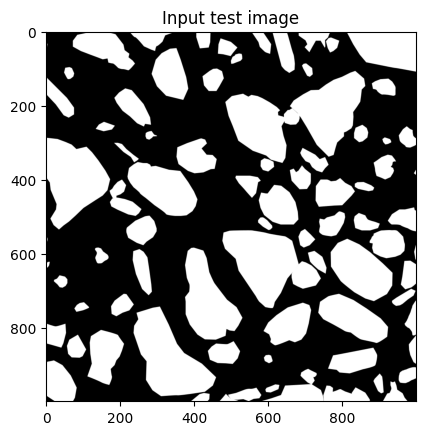

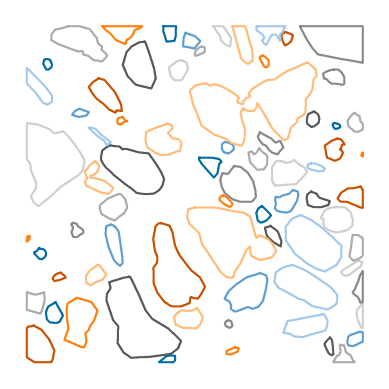

In [ ]:
filename = '/content/new_surface_recorte.png'
# filename = '/content/new_surface.png'
# filename = '/content/blocks.png'
#filename = 'MS.png'
#filename = 'TypoAN1.png'
#filename = "UK_coastline_MS.png"
img = cv2.imread(filename)
plt.imshow(img)
plt.title("Input test image")
plt.show()

# Find contours with certain threshold.. (manual job depends on the image)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

def extract_contours(contours):
    myconts = {}
    for i, contour in enumerate(contours):
        myconts[str(i)] = np.array(contour)
    return myconts

def plot_contours(contours_dict):
    for k, cont in enumerate(contours_dict):
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        coord = contours_dict[str(cont)][:, 0, :]
        plt.plot(coord[:, 0], -coord[:, 1], label="C#{}".format(cont))
        plt.gca().set_aspect('equal')
        plt.axis('off')
    #plt.legend()

myconts = extract_contours(contours)
del myconts['1']
del myconts['5']
del myconts['29']
del myconts['31']
del myconts['68']

with open('micro_8_contours_uniform.pkl', 'wb') as f:
    pickle.dump(myconts, f)
# if '271' in myconts:
#     del myconts['271']
#     print("chave 271 str deletada")
# elif 271 in myconts:
#     del myconts[271]
#     print("chave 271 int deletada")
# else:
#     print("Chave não encontrada (nem como string nem como int).")
plot_contours(myconts)


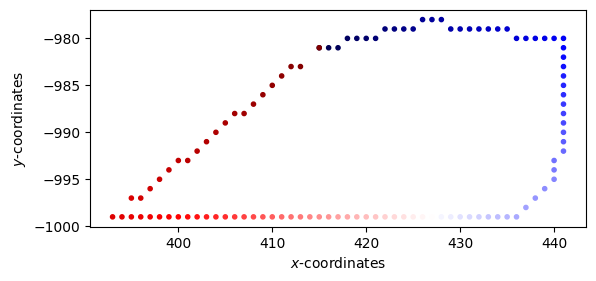

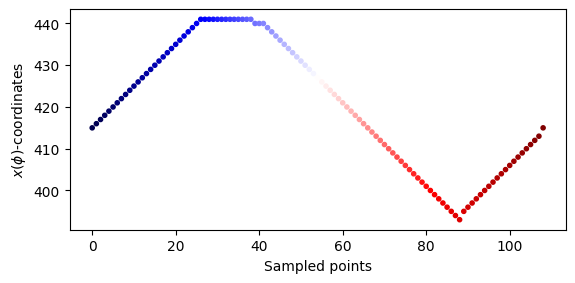

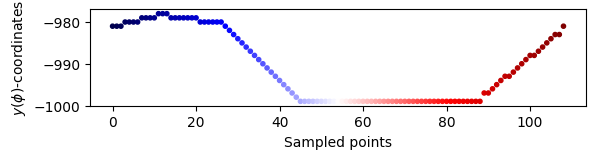

In [ ]:
# Make an arranged loop of the coordinates that can be connected with a line

import numpy as np

# Make an arranged loop of the coordinates that can be connected with a line

def make_looped_contour(coordinates):
    coordinates = np.unique(coordinates, axis=0)
    new_coordinates =  np.zeros(coordinates.shape)
    _updated_coord = np.zeros(new_coordinates.shape)

    threshold = max([max(coordinates[:,0]), max(coordinates[:,0])]) ** 20
    # pick up the first point (closet to the origin)
    _temp_rads = np.sqrt(coordinates[:, 0]**2 + coordinates[:, 1]**2)
    # wander = np.where(_temp_rads == min(_temp_rads))
    # wander_2 = (wander[0][:1],)
    # new_coordinates[0, :] = coordinates[wander_2, :]
    new_coordinates[0, :] = coordinates[np.where(_temp_rads == min(_temp_rads)), :]
    coordinates[np.where(_temp_rads == min(_temp_rads)), :] = [threshold, threshold]

    for i in range(1, len(coordinates[:,0])-2):
        _updated_coord[:, 0] = coordinates[:, 0] - new_coordinates[i-1, 0]
        _updated_coord[:, 1] = coordinates[:, 1] - new_coordinates[i-1, 1]
        _temp_rads = np.sqrt(_updated_coord[:, 0]**2 + _updated_coord[:, 1]**2)
        _curernt_idx = np.where(_temp_rads == min(_temp_rads))
        try:
            new_coordinates[i, :] = coordinates[_curernt_idx, :]
        except:
            # In case we have more than one point with equal distances take the first
            temp = coordinates[_curernt_idx, :]
            new_coordinates[i, :] = temp[0,0, :]
        coordinates[_curernt_idx, :] = [threshold, threshold]

    # Close the loop...
    new_coordinates[i+1, :] = new_coordinates[0, :]
    new_coordinates = np.delete(new_coordinates,(i+2), axis=0)
    return new_coordinates


def parameterise_contours(contours_dict, normalize_scale=False, normalize_location=False):
    para_conts = {}
    for i, contour in enumerate(contours_dict):
        coord = contours_dict[str(contour)][:, 0, :]
        new_coord = make_looped_contour(coord)
        if normalize_scale:
            scale_x = max(new_coord[:,0]) - min(new_coord[:,0])
            scale_y = max(new_coord[:,1]) - min(new_coord[:,1])
            new_coord[:,0] /= scale_x
            new_coord[:,1] /= scale_y
        if normalize_location:
            new_coord[:,0] -= np.mean(new_coord[:,0])
            new_coord[:,1] -= np.mean(new_coord[:,1])
        para_conts[str(i)] = new_coord
    return para_conts

mypara_conts = parameterise_contours(myconts)

test_coord = mypara_conts["0"]

# Create figure and axes
fig = plt.figure(1)
fig.clf()
cmap = cm.seismic
ax = fig.add_subplot(1, 1, 1)
c = np.arange(len(test_coord[:,0]))
ax.scatter(test_coord[:,0], -test_coord[:,1], c=c, marker='.', cmap=cmap)
plt.gca().set_aspect('equal')
#plt.axis('off')
plt.xlabel("$x$-coordinates")
plt.ylabel("$y$-coordinates")
plt.show()

'''
plt.plot(test_coord[:,0])
plt.title("The signal along the x-axis")
plt.gca().set_aspect('equal')
plt.ylabel("$x$-coordinates")
plt.xlabel("Sampled points")
plt.show()
'''

fig = plt.figure(1)
fig.clf()
cmap = cm.seismic
ax = fig.add_subplot(1, 1, 1)
c = np.arange(len(test_coord[:,0]))
ax.scatter(c, test_coord[:,0], c=c, marker='.', cmap=cmap)
plt.gca().set_aspect('equal')
#plt.axis('off')
plt.ylabel("$x(\phi)$-coordinates")
plt.xlabel("Sampled points")
plt.show()


'''
plt.plot(-test_coord[:,1])
plt.title("The signal along the y-axis")
plt.gca().set_aspect('equal')
plt.xlabel("Sampled points")
plt.ylabel("y-coordinates")
plt.show()
'''

fig = plt.figure(1)
fig.clf()
cmap = cm.seismic
ax = fig.add_subplot(1, 1, 1)
c = np.arange(len(test_coord[:,0]))
ax.scatter(c, -test_coord[:,1], c=c, marker='.', cmap=cmap)
plt.gca().set_aspect('equal')
#plt.axis('off')
plt.ylabel("$y(\phi)$-coordinates")
plt.xlabel("Sampled points")
plt.show()

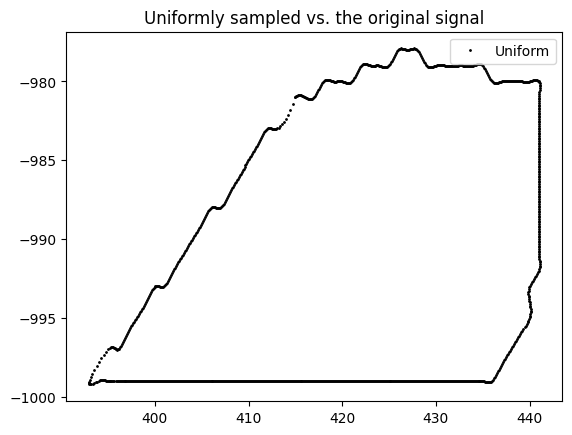

In [ ]:
# Resample the signals
def resample_nonuniform_signals(signal, points_num=2**8):
    _signal_x = np.linspace(1, len(signal), len(signal))
    new_signal_x = np.linspace(min(_signal_x), max(_signal_x), points_num)
    fcubic = interpolate.interp1d(_signal_x, signal, kind='cubic') #, kind='cubic'
    new_signal = fcubic(new_signal_x)
    return new_signal_x, new_signal

def uniformly_parameterised_contour(contours_dict, points_num=2**8):
    uni_para_conts = {}
    for i, contour in enumerate(contours_dict):
        coord = contours_dict[str(contour)]
        _, res_x = resample_nonuniform_signals(coord[:,0], points_num)
        _, res_y = resample_nonuniform_signals(coord[:,1], points_num)
        uni_para_conts[str(i)] = np.array([res_x, res_y])
    return uni_para_conts

# resampled_x1, resampled_y1 = resample_nonuniform_signals(new_coordinates1[:,1], 2**5)
myuni_para_conts = uniformly_parameterised_contour(mypara_conts, points_num=2**10)
coords_uni_x = myuni_para_conts["0"][0]; coords_uni_y = myuni_para_conts["0"][1]
coords_uni_x2 = myuni_para_conts["1"][0]; coords_uni_y2 = myuni_para_conts["1"][1]


plt.plot(coords_uni_x, -coords_uni_y, 'ok', label='Uniform', markersize=1)
#plt.plot(coords_uni_x2, -coords_uni_y2, '+b', label='Uniform', markersize=1)
plt.title("Uniformly sampled vs. the original signal")
plt.legend()
plt.show();

Max. Freq used was: 513


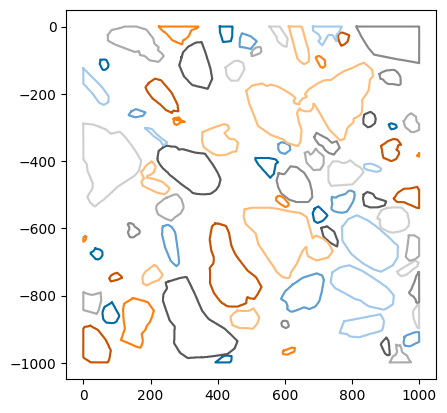

In [ ]:
def expand_signal_1D(signal_1D):
    # rFFT with conjugate symmetry assuming the inputs are only real
    coefs = np.fft.rfft(signal_1D, norm=None)
    return coefs

def reconstruct_1D_signal(coefs, max_freq):
    # irFFT with conjugate symmetry assuming the inputs are only real
    if max_freq != []:
        window = np.zeros(len(coefs))
        window[:max_freq] = 1
        rec_signal = np.fft.irfft(coefs*window, norm=None)
    else:
        rec_signal = np.fft.irfft(coefs, norm=None)
    return rec_signal.real

def expand_contour_signals(contours_dict, compute_moments=False):
    expand_conts = {}
    moments = {}
    for i, contour in enumerate(contours_dict):
        sig_x = expand_signal_1D(contours_dict[str(contour)][0])
        sig_y = expand_signal_1D(contours_dict[str(contour)][1])
        '''
        if np.any(np.iscomplex(sig_y)) or np.any(np.iscomplex(sig_y)):
            break;
        '''
        expand_conts[str(i)] = np.array([sig_x, sig_y])
        moments[str(i)] = sig_y * sig_y.conj() + sig_y * sig_y.conj()
    print("Max. Freq used was: {}".format(len(sig_y)))
    if compute_moments:
        return expand_conts, moments
    else:
        return expand_conts

def reconstruct_contour_signals(contours_dict, max_freq = [], specific_segments = []):
    rec_conts = {}
    for i, contour in enumerate(contours_dict):
        if specific_segments != []:
            #sig_x_sc = max(contours_dict[str(contour)][0])
            #sig_y_sc = max(contours_dict[str(contour)][1])
            sig_x = contours_dict[str(contour)][0][:specific_segments]
            #sig_x /= max(sig_x); sig_x *= sig_x_sc
            sig_y = contours_dict[str(contour)][1][:specific_segments]
            #sig_y /= max(sig_y); sig_y *= sig_y_sc
        else:
            sig_x = contours_dict[str(contour)][0]
            sig_y = contours_dict[str(contour)][1]
        rec_x = reconstruct_1D_signal(sig_x, max_freq)
        rec_y = reconstruct_1D_signal(sig_y, max_freq)

        # close the loops
        if specific_segments != []:
            rec_x = np.append(rec_x, rec_x[0])
            rec_y = np.append(rec_y, rec_y[0])
        rec_conts[str(contour)] = np.array([rec_x, rec_y])
    return rec_conts

def plot_surfaces(contours_dict):
    for k, co in enumerate(contours_dict):

        coord_x = contours_dict[str(k)][0]
        coord_y = -contours_dict[str(k)][1]
        plt.plot(coord_x, coord_y, label="C#{}".format(co))
    plt.gca().set_aspect('equal')
    #plt.axis('off')

    #plt.legend();

max_rec = 513#10**3
myrec_contours = reconstruct_contour_signals(expand_contour_signals(myuni_para_conts), max_rec)
test_rec_x, test_rec_y = myrec_contours["0"][0], myrec_contours["0"][1]
#test_rec_x2, test_rec_y2 = myrec_contours["1"][0], myrec_contours["1"][1]

plot_surfaces(myrec_contours)

# PSD moments

Max. Freq used was: 513
73


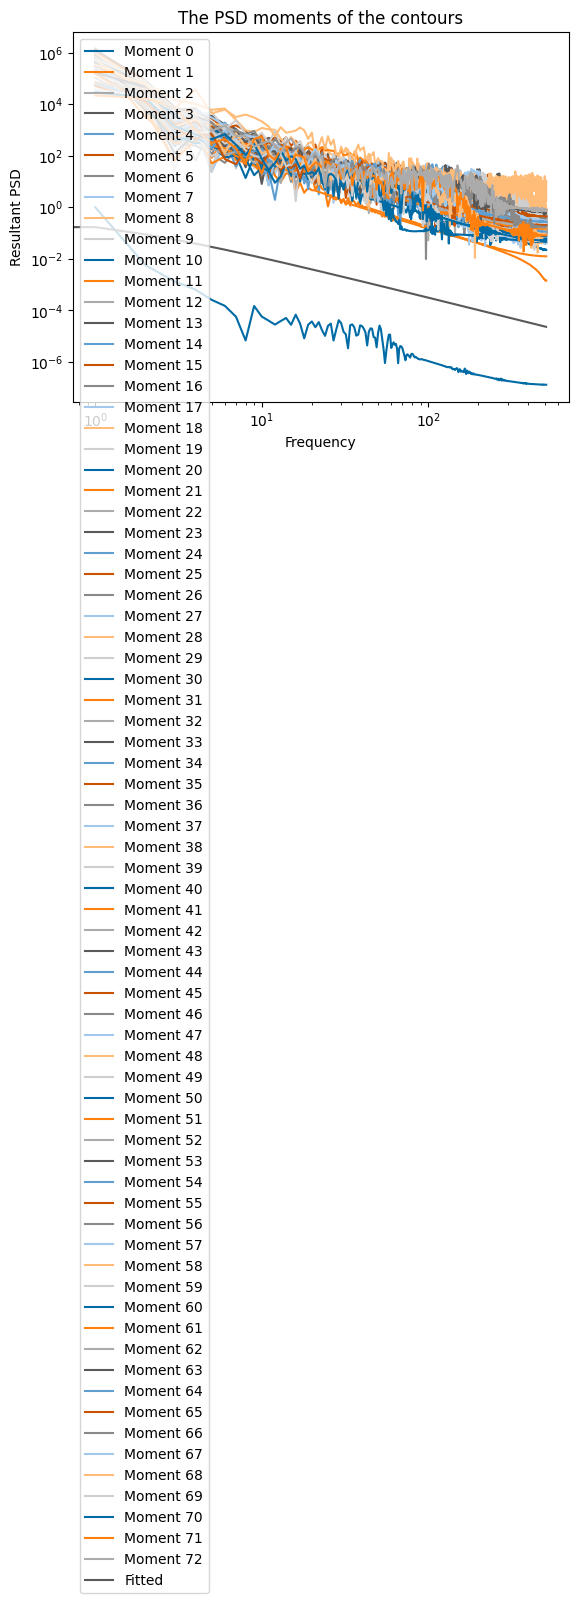

In [ ]:
_, my_moments = expand_contour_signals(myuni_para_conts, True)

H = 0.7
eigenvalues = np.linspace(1, 512, 512)

Beta = -1*(2+2*H)
Beta = -3.212 * 0.5
FITTED_LINE = 0.52 * eigenvalues**(Beta)

PSD = my_moments[str(0)][:-1].real
print(len(my_moments))

PSD /= PSD[0] # Normalise the PSD (not importanat but to have resonable numbers)

# www = []
for i, moments in enumerate(my_moments):
    # if np.sqrt(my_moments[str(i)][:-1].real)[0] > 1E7:
    #    www.append(i)
    #    print(i, np.sqrt(my_moments[str(i)][:-1].real)[0])
    plt.loglog(eigenvalues, np.sqrt(my_moments[str(i)][:-1].real), label="Moment {}".format(i))
plt.loglog(FITTED_LINE[0:], label="Fitted")
plt.legend()
plt.title("The PSD moments of the contours")
plt.xlabel("Frequency")
plt.ylabel("Resultant PSD");

def fitfun(x, y):
    fit = np.polyfit(np.log(x), np.log(y), 1)
    return fit

np.savetxt("PSD_data.csv", PSD, delimiter=",")

# fitness = fitfun(eigenvalues, PSD[1:]) # Not working for some reason
# print(fitness)

# Simplified stones

Max. Freq used was: 513


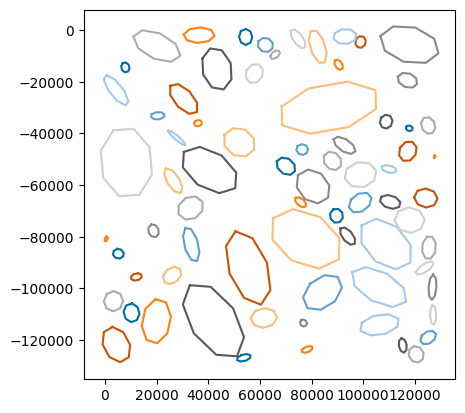

In [ ]:
segments = 5#10**3
# max_rec2 = 3#10**1
# final_max_freq = min([max_rec2, segments])
final_max_freq = [] # To use the max freq found!
final_max_freq = 2
myrec_contours_custom = reconstruct_contour_signals(expand_contour_signals(myuni_para_conts), final_max_freq, specific_segments = segments)

plot_surfaces(myrec_contours_custom)
#plot_contours(myconts)



# Use GMSH to remesh the contour

In [ ]:
def FEM_contour_mesh(contours_dict, mesh_size=10, boundary_offsets = 0., add_boundary=True,
                     mesh_file_name="Contour0.geo"):
    f=open(mesh_file_name,'w')
    f.write('//A simple example for remeshing contours by Mahmoud Shaqfa\n')
    #f.write('SetFactory("OpenCASCADE"); // opencascade kernel\n')
    f.write('SetFactory("Built-in");\n')

    f.write('Geometry.Tolerance = 1e-10;\n')
    # Write contours

    # Defed global lists and dicts
    iteretables = [1, 1]
    surfaces = []
    plst = []
    llist = []
    lloop = []

    # For the bounding box
    max_coord_x = -np.inf
    max_coord_y = -np.inf
    min_coord_x = np.inf
    min_coord_y = np.inf

    point_idx = 1
    line_idx = 1
    lineloop_idx = 1
    surface_idx = 1
    for k, co in enumerate(contours_dict):
        new_plist = []
        new_llist = []
        new_surflist = []
        text_object = []
        text_object.append("\n//Add stone {}\n".format(k))
        x = contours_dict[str(k)][0]
        y = -contours_dict[str(k)][1]
        if min(x) < min_coord_x: min_coord_x = min(x)
        if min(y) < min_coord_y: min_coord_y = min(y)
        if max(x) > max_coord_x: max_coord_x = max(x)
        if max(y) > max_coord_y: max_coord_y = max(y)

        # Create points
        for i in range(len(x)):
            text_object.append('Point({}) = {{{},{},{},{}}};\n'.format(point_idx, x[i-1], y[i-1], 0, mesh_size))
            new_plist.append(point_idx)
            point_idx += 1
        plst.extend(new_plist)
        # Create lines
        for i in range(len(new_plist)-1):
            text_object.append('Line({}) = {{{},{}}};\n'.format(line_idx, new_plist[i], new_plist[i+1]))
            new_llist.append(line_idx)
            line_idx += 1
        # Closeing line
        text_object.append('Line({}) = {{{},{}}}; //closing line\n'.format(line_idx, new_plist[-1], new_plist[0]))
        new_llist.append(line_idx)
        line_idx += 1
        # Line loops
        lines_loop = ','.join([str(kk) for _, kk in enumerate(new_llist)])
        text_object.append('Line Loop ({}) = {{{}}};\n'.format(lineloop_idx, lines_loop))
        lloop.append(lineloop_idx)
        lineloop_idx += 1
        # Write a surface
        text_object.append('Plane Surface ({}) = {{{}}};\n'.format(surface_idx, lineloop_idx-1))
        new_surflist.append(surface_idx)
        surface_idx += 1
        surfaces.extend(new_surflist)
        f.writelines(text_object)

    # Add physical surfaces (stones)
    phys_surf = ','.join([str(kk) for _, kk in enumerate(surfaces)])
    f.write('Physical Surface("Stones") = {{ {} }};\n'.format(phys_surf))
    text_object = []
    # Add boundary for a buffer box
    rect_list = []
    new_llist = []
    min_coord_x -= boundary_offsets
    max_coord_x += boundary_offsets
    min_coord_y -= boundary_offsets
    max_coord_y += boundary_offsets

    if add_boundary:
        text_object.append("\n//Add mortar matrix\n")
        point_idx = max(plst)+1
        # Create points
        text_object.append('Point({}) = {{{},{},{},{}}};\n'.format(point_idx, min_coord_x, min_coord_y, 0, mesh_size))
        rect_list.append(point_idx); point_idx += 1
        text_object.append('Point({}) = {{{},{},{},{}}};\n'.format(point_idx, max_coord_x, min_coord_y, 0, mesh_size))
        rect_list.append(point_idx); point_idx += 1
        text_object.append('Point({}) = {{{},{},{},{}}};\n'.format(point_idx, max_coord_x, max_coord_y, 0, mesh_size))
        rect_list.append(point_idx); point_idx += 1
        text_object.append('Point({}) = {{{},{},{},{}}};\n'.format(point_idx, min_coord_x, max_coord_y, 0, mesh_size))
        rect_list.append(point_idx); point_idx += 1
        # Create lines
        text_object.append('Line({}) = {{{},{}}};\n'.format(line_idx, rect_list[0], rect_list[1]))
        new_llist.append(line_idx); line_idx += 1
        text_object.append('Line({}) = {{{},{}}};\n'.format(line_idx, rect_list[1], rect_list[2]))
        new_llist.append(line_idx); line_idx += 1
        text_object.append('Line({}) = {{{},{}}};\n'.format(line_idx, rect_list[2], rect_list[3]))
        new_llist.append(line_idx); line_idx += 1
        text_object.append('Line({}) = {{{},{}}}; //closing line\n'.format(line_idx, rect_list[3], rect_list[0]))
        new_llist.append(line_idx); line_idx += 1
        # Line loops
        lines_loop = ','.join([str(kk) for _, kk in enumerate(new_llist)])
        text_object.append('Line Loop ({}) = {{{}}};\n'.format(lineloop_idx, lines_loop))
        lloop.append(lineloop_idx)

        lineloop_loop = ','.join([str(kk) for _, kk in enumerate(lloop)])
        text_object.append('Plane Surface ({}) = {{{}}};\n'.format(surface_idx, lineloop_loop))
        f.writelines(text_object)
        f.write('Physical Surface("Mortar") = {{ {} }};\n'.format(surface_idx))

    f.write('\n\n')
    # Boolean processes (subtract stones from the mortar)
    #f.write('Geometry.AutoCoherence = 2')
    f.write('Coherence;\n')

    # Mesh and save, then end :)
    f.write('Mesh 1;\n')
    f.write('Mesh 2;\n')
    f.write('Coherence Mesh;\n')
    f.write('Coherence;\n')
    f.write('Save "{}";'.format(mesh_file_name[:-4]+'.msh'))
    f.close()

def plot_FEM_mesh(mesh_file=""):
    pass

mesh_output_file = "Test_contour"
FEM_contour_mesh(myrec_contours_custom, mesh_size=2500, boundary_offsets = 200, add_boundary=True, mesh_file_name=mesh_output_file+".geo")

shell_output = subprocess.run('gmsh {} -2 {}'.format(mesh_output_file+".geo", mesh_output_file+".msh"), shell=True)
print(shell_output)
"""
gmsh <name_of_your_geo_file.geo> -2 <-o name_of_the_output_file>
""";

CompletedProcess(args='gmsh Test_contour.geo -2 Test_contour.msh', returncode=0)


In [ ]:
# Visualize meshes
from IPython.display import SVG
def show_svg(fname, url=None):
    return SVG(url=url, filename=fname)

import meshio
mesh = meshio.read(filename="./"+mesh_output_file+".msh")
mesh.write("./"+mesh_output_file+".svg")
#show_svg("./"+mesh_output_file+".svg")

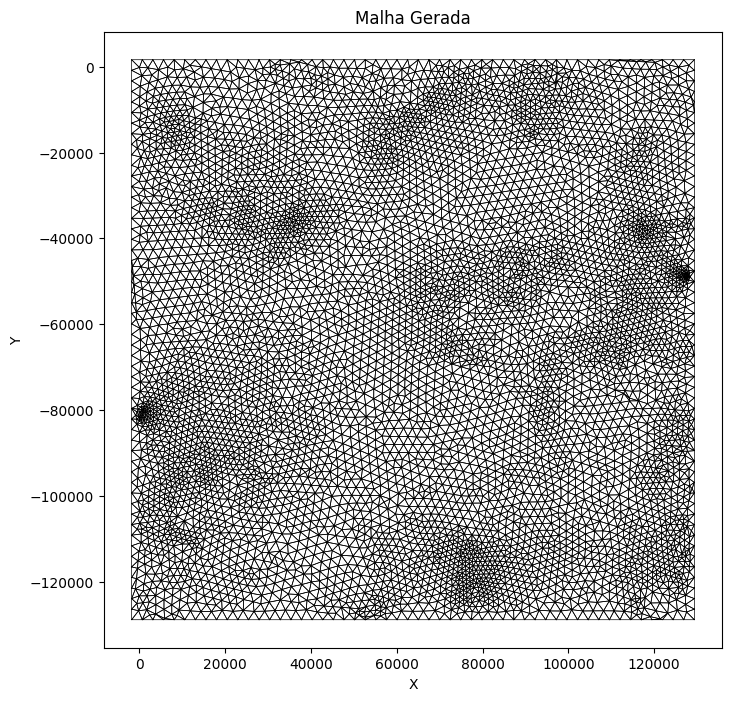

In [ ]:
import matplotlib.pyplot as plt
import meshio

mesh = meshio.read("Test_contour.msh")
points = mesh.points
cells = mesh.cells_dict.get("triangle", None)  # ou "line" se for malha 1D

if cells is not None:
    plt.figure(figsize=(8, 8))
    for triangle in cells:
        tri_pts = points[triangle]
        x = list(tri_pts[:, 0]) + [tri_pts[0, 0]]
        y = list(tri_pts[:, 1]) + [tri_pts[0, 1]]
        plt.plot(x, y, 'k-', linewidth=0.5)

    plt.gca().set_aspect('equal')
    plt.title("Malha Gerada")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
else:
    print("Nenhuma célula triangular encontrada na malha.")

/tmp/ipython-input-71-1794239342.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", n_groups)


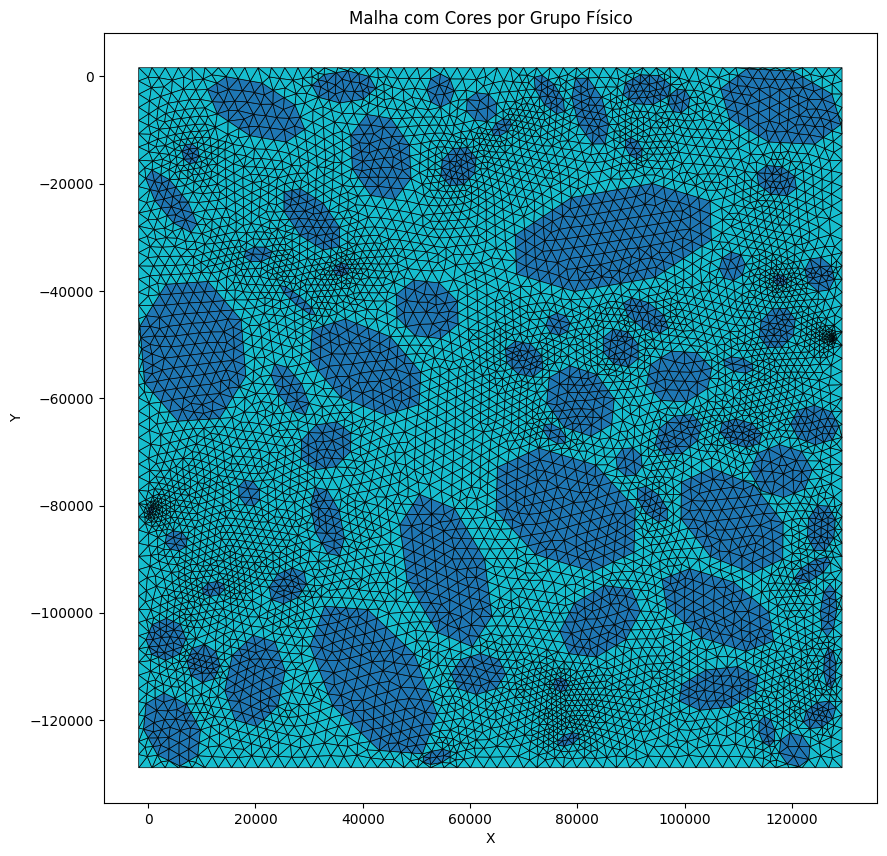

In [ ]:
import matplotlib.pyplot as plt
import meshio
import numpy as np
import matplotlib.colors as mcolors

# Carrega a malha
mesh = meshio.read("Test_contour.msh")
points = mesh.points
cells = mesh.cells_dict.get("triangle", None)
cell_data = mesh.cell_data_dict.get("gmsh:physical", {}).get("triangle", None)

if cells is not None and cell_data is not None:
    # Cores distintas por grupo físico
    group_ids = np.unique(cell_data)
    n_groups = len(group_ids)
    color_map = plt.cm.get_cmap("tab10", n_groups)
    colors = {group_id: color_map(i) for i, group_id in enumerate(group_ids)}

    plt.figure(figsize=(10, 10))
    for i, triangle in enumerate(cells):
        tri_pts = points[triangle]
        x = list(tri_pts[:, 0]) + [tri_pts[0, 0]]
        y = list(tri_pts[:, 1]) + [tri_pts[0, 1]]
        group_id = cell_data[i]
        plt.fill(x, y, color=colors[group_id], edgecolor='k', linewidth=0.5)

    plt.gca().set_aspect('equal')
    plt.title("Malha com Cores por Grupo Físico")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
else:
    print("Malha triangular ou grupos físicos não encontrados.")


In [ ]:
# https://gitlab.onelab.info/gmsh/gmsh/blob/master/tutorials/python/t1.py
# https://gitlab.onelab.info/gmsh/gmsh/-/tree/master/tutorials/python


## Useful papers where this concept was used for particles:


Mollon, G., Quacquarelli, A., Andò, E. et al. Can friction replace roughness in the numerical simulation of granular materials?. Granular Matter 22, 42 (2020). https://doi.org/10.1007/s10035-020-1004-5

Mollon, G., Zhao, J. Fourier–Voronoi-based generation of realistic samples for discrete modelling of granular materials. Granular Matter 14, 621–638 (2012). https://doi.org/10.1007/s10035-012-0356-x

Simon J. Blott, Kenneth Pye. Particle shape: a review and new methods of characterization and classification, https://doi.org/10.1111/j.1365-3091.2007.00892.xCitationsfor

Remeber: The algorithm was first used in the 70's of the last century and was called the *"Elliptical Fourier Descriptors"*.